In [1]:
import pandas as pd
wine = pd.read_csv("https://bit.ly/wine_csv_data")

In [2]:
data   = wine[["alcohol", "sugar", "pH"]].to_numpy()
target = wine["class"].to_numpy()

In [3]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(data, target ,test_size = 0.2, random_state = 42)

In [4]:
# for re-traing after fining the best optimized parameter(s)
# for cross validation

sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size = 0.2, random_state = 42)

In [6]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [9]:
# Fit with decision tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state = 42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

# According to the score, this model is obviously overfitted to the training dataset

0.9971133028626413
0.864423076923077


In [18]:
# Cross validation for k-fold cross validation
# Scikit-learn package provides a dedication method for it
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.01113296, 0.01001954, 0.01055717, 0.01066875, 0.0101614 ]), 'score_time': array([0.00161791, 0.00156236, 0.00163245, 0.00163198, 0.00161004]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [19]:
import numpy as np

print(np.mean(scores["test_score"]))    # Calculate an average score of overall validation trials

0.855300214703487


In [21]:
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv = StratifiedKFold())
print(np.mean(scores["test_score"]))

0.855300214703487


In [24]:
# If I wanna conduct a 10-fold cross validation

splitter = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
scores   = cross_validate(dt, train_input, train_target, cv = splitter)

print(np.mean(scores["test_score"]))

0.8574181117533719


In [28]:
# grid search serializes hyperparameter discovery and cross validation procedures.
from sklearn.model_selection import GridSearchCV

params = {
    "min_impurity_decrease" : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
}
gs = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, n_jobs = -1)

In [29]:
# Conduct a grid search after finishing initial configuration
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [30]:
dt = gs.best_estimator_     # The best fitted model
print(dt.score(train_input, train_target))

0.9615162593804117


In [31]:
print(gs.best_params_)      # What was the best parameter?

{'min_impurity_decrease': 0.0001}


In [32]:
print(gs.cv_results_["mean_test_score"])    # Print the overall average cross validation result (score(test))

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [34]:
best_index = np.argmax(gs.cv_results_["mean_test_score"])    # Based on the test score, find the most optimized parameter value
print(gs.cv_results_["params"][best_index])

{'min_impurity_decrease': 0.0001}


In [35]:
# More complicated grid search conducting
params = {
    "min_impurity_decrease" : np.arange(0.0001, 0.001, 0.0001),
    "max_depth"             : range(5, 20, 1),
    "min_samples_split"     : range(2, 100, 10)
}

gs = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, n_jobs = -1)
gs.fit(train_input, train_target)

print(gs.best_params_)
print(np.max(gs.cv_results_["mean_test_score"]))

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}
0.8683865773302731


In [36]:
# random search

In [37]:
from scipy.stats import uniform, randint

rgen = randint(0, 10)
rgen.rvs(10)

array([4, 0, 5, 7, 9, 4, 6, 9, 3, 4])

In [38]:
np.unique(rgen.rvs(1000), return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 99, 100,  98,  86, 110, 110, 111, 105,  88,  93]))

In [39]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.32649386, 0.05120034, 0.48038471, 0.84359534, 0.60392529,
       0.45700008, 0.26564826, 0.56799721, 0.45957688, 0.73345447])

In [51]:
params = {
    "min_impurity_decrease" : uniform(0.0001, 0.001),
    "max_depth"             : randint(20, 50),
    "min_samples_split"     : randint(2, 25),
    "min_samples_leaf"      : randint(1, 25)
}

from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state = 42), params, n_iter = 100, n_jobs = -1, random_state = 42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7faa74ff5f30>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7faa74ff7be0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7faa74ff5420>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7faa74ff4970>},
                   random_state=42)

In [52]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [53]:
print(np.max(gs.cv_results_["mean_test_score"]))

0.8695428296438884


In [54]:
dt = gs.best_estimator_
print(dt.score(test_input, test_target))

0.86


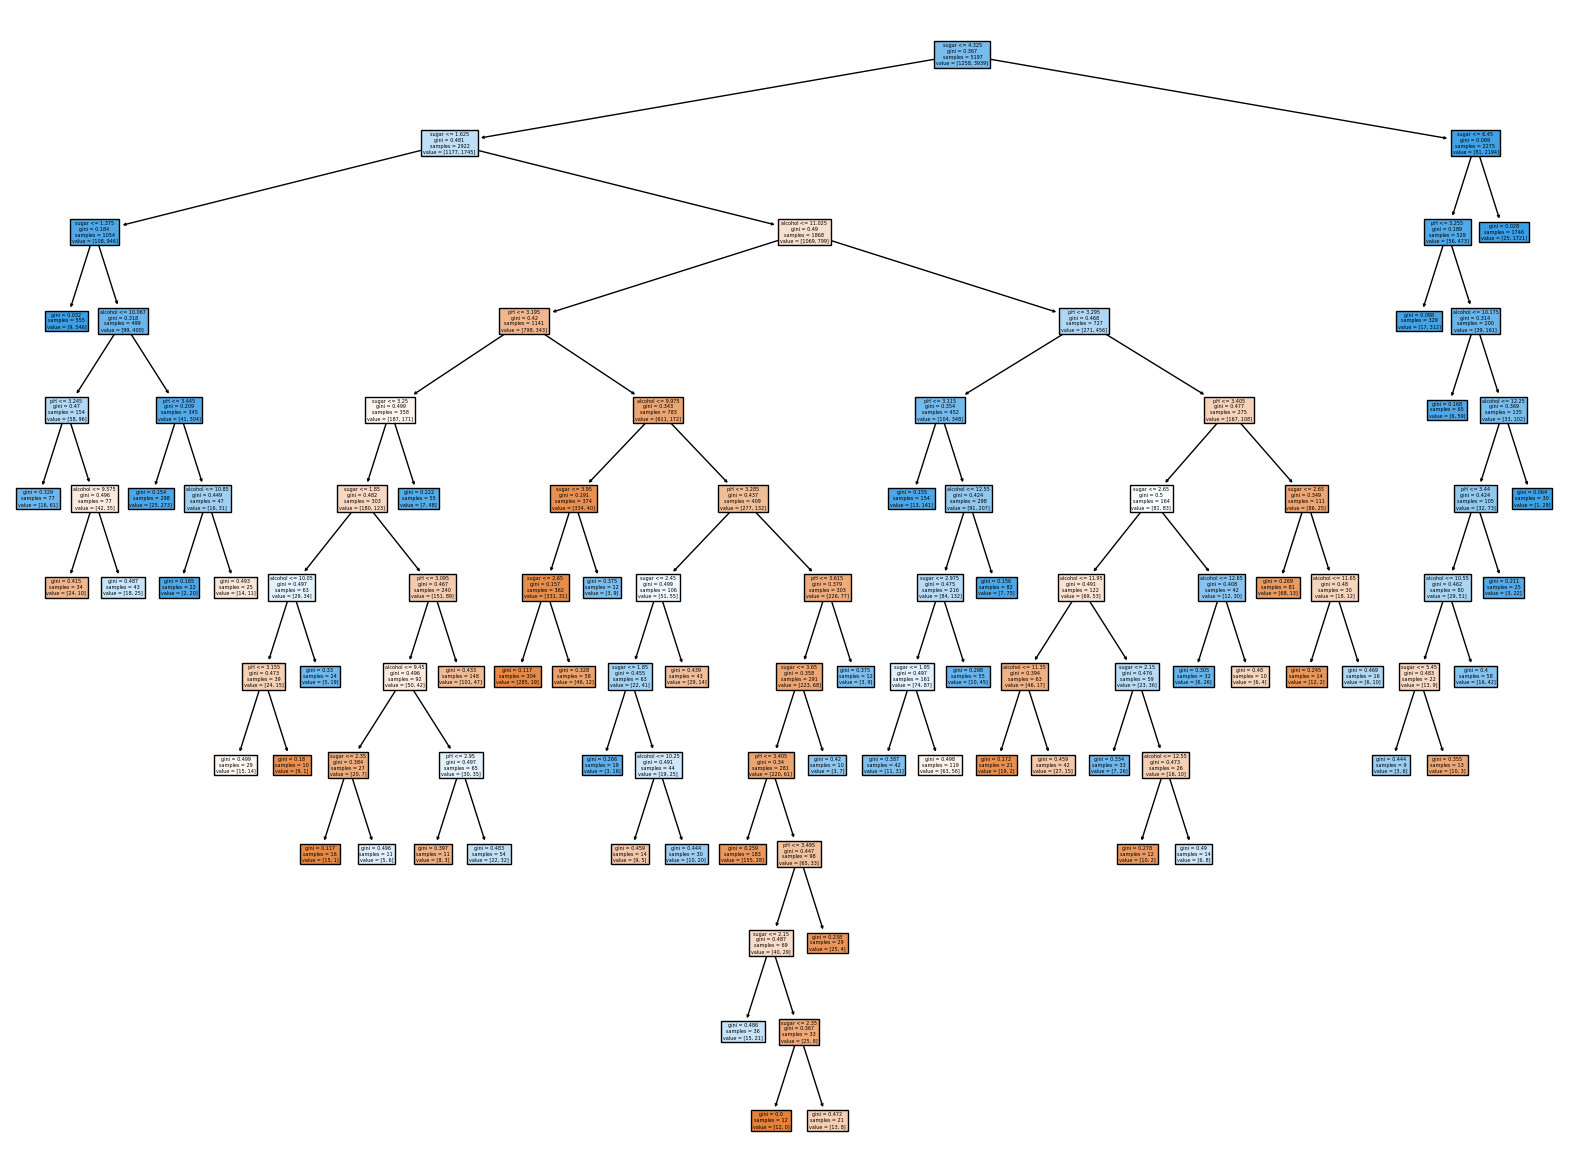

In [58]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize = (20, 15))

plot_tree(dt, filled = True, feature_names = ["alcohol", "sugar", "pH"])
plt.show()